# **FORESTFIRES**

In [51]:
!pip install tensorflow

In [52]:
!pip install keras

In [53]:
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np


In [54]:
forestfire=pd.read_csv('/content/forestfires.csv')

In [55]:

forestfire.drop(["month","day"],axis=1,inplace = True)

In [56]:
forestfire["size_category"].value_counts()
forestfire.isnull().sum()
forestfire.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292,0.164410,0.143133,0.162476,0.183752,0.117988,0.123791,0.104449,0.017408,0.355899,0.017408,0.038685,0.003868,0.061896,0.032882,0.104449,0.003868,0.001934,0.029014,0.332689
std,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818,0.371006,0.350548,0.369244,0.387657,0.322907,0.329662,0.306138,0.130913,0.479249,0.130913,0.193029,0.062137,0.241199,0.178500,0.306138,0.062137,0.043980,0.168007,0.471632
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [57]:
forestfire.loc[forestfire["size_category"]=='small','size_category']=0
forestfire.loc[forestfire["size_category"]=='large','size_category']=1
forestfire["size_category"].value_counts()

0    378
1    139
Name: size_category, dtype: int64

In [58]:
def norm_func(i):
     x = (i-i.min())  /  (i.max()  -  i.min())
     return (x)

In [59]:
predictors = forestfire.iloc[:,0:28]
target = forestfire.iloc[:,28]

In [60]:
predictors1 = norm_func(predictors)

In [61]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(predictors1,target, test_size=0.3,stratify = target)

In [62]:
def prep_model(hidden_dim):
    model = Sequential()
    for i in range(1,len(hidden_dim)-1):
        if (i==1):
            model.add(Dense(hidden_dim[i],input_dim=hidden_dim[0],activation="relu"))
        else:
            model.add(Dense(hidden_dim[i],activation="relu"))
    model.add(Dense(hidden_dim[-1],kernel_initializer="normal",activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer = "rmsprop",metrics = ["accuracy"])
    return model

In [63]:
first_model = prep_model([28,50,40,20,1])
pred_train = first_model.predict(np.array(x_train))

In [64]:
pred_train = pd.Series([i[0] for i in pred_train])

In [65]:
size = ["small","large"]
pred_train_class = pd.Series(["small"]*361)
pred_train_class[[i>0.5 for i in pred_train]]= "large"

In [66]:
train = pd.concat([x_train,y_train],axis=1)
train["size_category"].value_counts()

0    264
1     97
Name: size_category, dtype: int64

In [67]:
from sklearn.metrics import confusion_matrix
train["original_class"] = "small"
train.loc[train["size_category"]==1,"original_class"] = "large"
train.original_class.value_counts()
confusion_matrix(pred_train_class,train["original_class"])
np.mean(pred_train_class==pd.Series(train["original_class"]).reset_index(drop=True)) #100%
pd.crosstab(pred_train_class,pd.Series(train["original_class"]).reset_index(drop=True))

original_class,large,small
row_0,,
large,61,171
small,36,93


In [68]:
pred_test = first_model.predict(np.array(x_test))
pred_test = pd.Series([i[0] for i in pred_test])
pred_test_class = pd.Series(["small"]*156)
pred_test_class[[i>0.5 for i in pred_test]] = "large"
test =pd.concat([x_test,y_test],axis=1)
test["original_class"]="small"
test.loc[test["size_category"]==1,"original_class"] = "large"

test["original_class"].value_counts()
np.mean(pred_test_class==pd.Series(test["original_class"]).reset_index(drop=True)) # 85%
confusion_matrix(pred_test_class,test["original_class"])
pd.crosstab(pred_test_class,pd.Series(test["original_class"]).reset_index(drop=True))

original_class,large,small
row_0,,
large,26,77
small,16,37


# **GAS TURBINE**

In [69]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Layer,Lambda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [70]:
gasturbines=pd.read_csv('/content/gas_turbines.csv')


In [71]:
gasturbines.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


In [72]:
gasturbines.isnull().sum()
gasturbines.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,15039.000000,15039.00000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000
mean,17.764381,1013.19924,79.124174,4.200294,25.419061,1083.798770,545.396183,134.188464,12.102353,1.972499,68.190934
std,7.574323,6.41076,13.793439,0.760197,4.173916,16.527806,7.866803,15.829717,1.103196,2.222206,10.470586
min,0.522300,985.85000,30.344000,2.087400,17.878000,1000.800000,512.450000,100.170000,9.904400,0.000388,27.765000
25%,11.408000,1008.90000,69.750000,3.723900,23.294000,1079.600000,542.170000,127.985000,11.622000,0.858055,61.303500
50%,18.186000,1012.80000,82.266000,4.186200,25.082000,1088.700000,549.890000,133.780000,12.025000,1.390200,66.601000
75%,23.862500,1016.90000,90.043500,4.550900,27.184000,1096.000000,550.060000,140.895000,12.578000,2.160400,73.935500
max,34.929000,1034.20000,100.200000,7.610600,37.402000,1100.800000,550.610000,174.610000,15.081000,44.103000,119.890000


In [73]:

gasturbines.shape

(15039, 11)

In [74]:
def norm_func(i):
     x = (i-i.min())  /  (i.max()  -  i.min())
     return (x)

In [75]:
ambient = gasturbines.iloc[:,0:8]
variables = gasturbines.iloc[:,8]

In [76]:
ambient1 = norm_func(ambient)

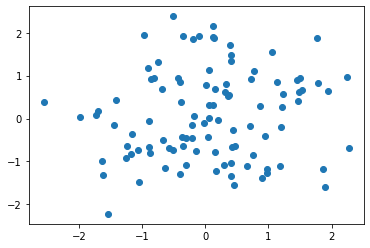

In [77]:
plt.scatter(x, y);

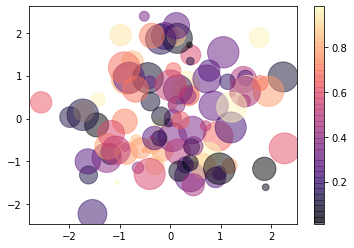

In [78]:
rng = np.random.RandomState(0)
x = rng.randn(100)
y = rng.randn(100)
colors = rng.rand(100)
sizes = 1000 * rng.rand(100)

plt.scatter(x, y, c=colors, s=sizes, alpha=0.5,
            cmap='magma')
plt.colorbar();

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a065ac610>,
      dtype=object)

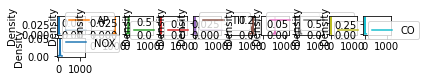

In [79]:
gasturbines.plot(kind='density', subplots=True, layout=(10,10), sharex=True, sharey=False)

AT        AxesSubplot(0.125,0.821923;0.0596154x0.0580769)
AP      AxesSubplot(0.196538,0.821923;0.0596154x0.0580...
AH      AxesSubplot(0.268077,0.821923;0.0596154x0.0580...
AFDP    AxesSubplot(0.339615,0.821923;0.0596154x0.0580...
GTEP    AxesSubplot(0.411154,0.821923;0.0596154x0.0580...
TIT     AxesSubplot(0.482692,0.821923;0.0596154x0.0580...
TAT     AxesSubplot(0.554231,0.821923;0.0596154x0.0580...
TEY     AxesSubplot(0.625769,0.821923;0.0596154x0.0580...
CDP     AxesSubplot(0.697308,0.821923;0.0596154x0.0580...
CO      AxesSubplot(0.768846,0.821923;0.0596154x0.0580...
NOX     AxesSubplot(0.840385,0.821923;0.0596154x0.0580...
dtype: object

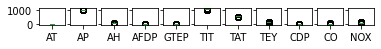

In [80]:
gasturbines.plot(kind='box', subplots=True, layout=(11,11), sharex=False, sharey=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a02166fd0>,
      dtype=object)

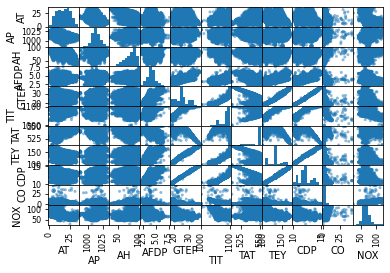

In [81]:
pd.plotting.scatter_matrix(gasturbines)

[Text(0, 0, 'AT'),
 Text(0, 0, 'AP'),
 Text(0, 0, 'AH'),
 Text(0, 0, 'AFDP'),
 Text(0, 0, 'GTEP'),
 Text(0, 0, 'TIT'),
 Text(0, 0, 'TAT'),
 Text(0, 0, 'TEY'),
 Text(0, 0, 'CDP'),
 Text(0, 0, 'CO'),
 Text(0, 0, 'NOX')]

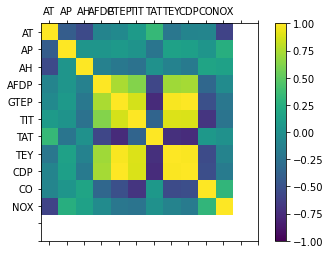

In [82]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(gasturbines.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,13,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(gasturbines.columns)
ax.set_yticklabels(gasturbines.columns)

In [83]:
print("Correlation:", gasturbines.corr(method='pearson'))

Correlation:             AT        AP        AH  ...       CDP        CO       NOX
AT    1.000000 -0.412953 -0.549432  ... -0.100705 -0.088588 -0.600006
AP   -0.412953  1.000000  0.042573  ...  0.131198  0.041614  0.256744
AH   -0.549432  0.042573  1.000000  ... -0.182010  0.165505  0.143061
AFDP -0.099333  0.040318 -0.119249  ...  0.727152 -0.334207 -0.037299
GTEP -0.049103  0.078575 -0.202784  ...  0.993784 -0.508259 -0.208496
TIT   0.093067  0.029650 -0.247781  ...  0.887238 -0.688272 -0.231636
TAT   0.338569 -0.223479  0.010859  ... -0.744740  0.063404  0.009888
TEY  -0.207495  0.146939 -0.110272  ...  0.988473 -0.541751 -0.102631
CDP  -0.100705  0.131198 -0.182010  ...  1.000000 -0.520783 -0.169103
CO   -0.088588  0.041614  0.165505  ... -0.520783  1.000000  0.316743
NOX  -0.600006  0.256744  0.143061  ... -0.169103  0.316743  1.000000

[11 rows x 11 columns]
